# 🏆 CIFAR-10 Image Classification with CNN

## 📋 **Project Overview**
This notebook implements a **Convolutional Neural Network (CNN)** for multi-class image classification on the famous **CIFAR-10 dataset**. The CIFAR-10 dataset consists of 60,000 32x32 color images across 10 different categories.

### 🎯 **Objectives:**
- Build and train a CNN model from scratch using TensorFlow/Keras
- Achieve high accuracy on CIFAR-10 image classification
- Implement data augmentation techniques for better generalization
- Perform comprehensive model evaluation and analysis

### 📊 **Dataset Information:**
- **Images**: 60,000 total (50,000 train + 10,000 test)
- **Image Size**: 32×32 pixels, RGB color
- **Classes**: 10 categories
  - 🛩️ airplane, 🚗 automobile, 🐦 bird, 🐱 cat, 🦌 deer
  - 🐶 dog, 🐸 frog, 🐴 horse, 🚢 ship, 🚛 truck

---

## 📚 **Step 1: Import Required Libraries**

We'll import all necessary libraries for:
- **TensorFlow/Keras**: Deep learning framework for building CNN
- **Matplotlib**: Data visualization and plotting
- **NumPy/Pandas**: Data manipulation and analysis
- **Scikit-learn**: Model evaluation metrics

In [1]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import layers, models, datasets
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

2.20.0


## 📂 **Step 2: Dataset Loading and Preparation**

### 🔄 **Loading CIFAR-10 Dataset**
We use TensorFlow's built-in CIFAR-10 dataset loader which automatically:
- Downloads the dataset (if not already present)
- Loads 50,000 training images and 10,000 test images
- Provides labels as integers (0-9) for the 10 classes

### 📊 **Data Split Strategy:**
- **Training**: 80% of original training data (40,000 images)
- **Validation**: 20% of original training data (10,000 images)  
- **Testing**: Original test set (10,000 images)

This ensures we have proper train/validation/test splits for robust model evaluation.

In [2]:
cifar_dir = r'C:\Users\Asus\IE4483\IE4483datasets\cifar-10-batches-py'

# Load images from directory for training/validation
img_size = (32, 32)  # CIFAR-10 images are 32x32
batch_size = 16

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Use 80% of training data for training, 20% for validation
split_idx = int(0.8 * len(x_train))
x_val, y_val = x_train[split_idx:], y_train[split_idx:]
x_train, y_train = x_train[:split_idx], y_train[:split_idx]
print(f"Training samples: {len(x_train)}, Validation samples: {len(x_val)}, Test samples: {len(x_test)}")


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 85s 0us/step
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 85s 0us/step
Training samples: 40000, Validation samples: 10000, Test samples: 10000
Training samples: 40000, Validation samples: 10000, Test samples: 10000


In [3]:
# Convert numpy arrays to tf.data.Dataset and preprocess
def preprocess_data(x, y):
    x = tf.cast(x, tf.float32) / 255.0  # Normalize to [0,1]
    y = tf.squeeze(y)  # Remove extra dimension from labels
    return x, y

# Create tf.data.Dataset objects
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(preprocess_data).batch(batch_size)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.map(preprocess_data).batch(batch_size)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.map(preprocess_data).batch(batch_size)

print("✅ Created TensorFlow datasets with preprocessing")

✅ Created TensorFlow datasets with preprocessing


## 🔧 **Step 3: Data Preprocessing and Pipeline**

### 🎯 **Key Preprocessing Steps:**
1. **Normalization**: Scale pixel values from [0,255] to [0,1] for better training stability
2. **Label Processing**: Remove extra dimensions from labels for compatibility
3. **Batching**: Group images into batches of 16 for efficient GPU processing
4. **tf.data Pipeline**: Create optimized TensorFlow datasets with caching and prefetching

### ⚡ **Performance Optimizations:**
- **Caching**: Store preprocessed data in memory to avoid recomputation
- **Prefetching**: Load next batch while current batch is being processed
- **AUTOTUNE**: Let TensorFlow automatically optimize buffer sizes

In [4]:
# Inspect the datasets
for images, labels in train_ds.take(1):
    print(f"Training batch shape: {images.shape}")  # e.g. (16, 32, 32, 3)
    print(f"Training labels shape: {labels.shape}")  # e.g. (16,)
    print(f"Label range: {tf.reduce_min(labels).numpy()} to {tf.reduce_max(labels).numpy()}")

Training batch shape: (16, 32, 32, 3)
Training labels shape: (16,)
Label range: 1 to 9


In [5]:
def prepare(ds):
    return ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

train_ds = prepare(train_ds)
val_ds   = prepare(val_ds)
test_ds  = prepare(test_ds)

## 🧠 **Step 4: CNN Model Architecture Design**

### 🏗️ **Model Architecture Overview:**
Our CNN follows a classic architecture pattern optimized for CIFAR-10's 32×32 images:

**🔸 Feature Extraction Layers:**
- **3 Convolutional Blocks**: Each with Conv2D → MaxPooling → BatchNormalization
- **Progressive Filters**: 16 → 32 → 64 filters (increasing depth for complex features)
- **3×3 Kernels**: Standard size for effective feature detection
- **ReLU Activation**: Non-linearity for learning complex patterns

**🔸 Classification Layers:**
- **Flatten**: Convert 2D feature maps to 1D vector
- **Dense(64)**: Fully connected layer with L2 regularization
- **Dropout(0.5)**: Prevent overfitting during training
- **Dense(10)**: Output layer with softmax for 10-class probability distribution

### 🎯 **CIFAR-10 Classes:**
0: ✈️ airplane, 1: 🚗 automobile, 2: 🐦 bird, 3: 🐱 cat, 4: 🦌 deer,  
5: 🐶 dog, 6: 🐸 frog, 7: 🐴 horse, 8: 🚢 ship, 9: 🚛 truck

In [6]:
from tensorflow.keras import layers, models, regularizers

model = models.Sequential([
    layers.BatchNormalization(input_shape=(img_size[0], img_size[1], 3)),

    layers.Conv2D(16, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(),

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')  # CIFAR-10 has 10 classes
])


model.summary()

c:\Users\Asus\IE4483\venv\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 32, 32, 3)      │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,294 (352.71 KB)

 Trainable params: 90,064 (351.81 KB)

 Non-trainable params: 230 (920.00 B)

## 🎨 **Step 5: Data Augmentation Strategy**

### 🔄 **Augmentation Techniques Applied:**
Data augmentation helps the model generalize better by creating variations of training images:

- **🔄 Horizontal Flip**: Mirror images left-right (realistic for most objects)
- **🔄 Random Rotation**: Rotate images up to ±10% (0.1 radians ≈ 6°)  
- **🔍 Random Zoom**: Zoom in/out by up to 10% to simulate distance variations
- **🌓 Random Contrast**: Adjust contrast by ±10% for lighting variations

### 💡 **Benefits:**
- **Prevents Overfitting**: Model sees more diverse examples during training
- **Improves Generalization**: Better performance on unseen test data
- **Increases Dataset Size**: Virtually expands training data without new samples

In [7]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

## 🚀 **Step 6: Model Compilation and Training**

### ⚙️ **Training Configuration:**

**🎯 Optimizer**: **Adam** with learning rate 1e-4
- Adaptive learning rates for each parameter
- Combines benefits of AdaGrad and RMSprop
- Well-suited for sparse gradients and noisy problems

**📊 Loss Function**: **Sparse Categorical Crossentropy**
- Perfect for multi-class classification with integer labels
- No need to one-hot encode labels (0-9 directly)
- Efficient computation and memory usage

**📈 Metrics**: **Accuracy** for easy performance interpretation

**🛑 Early Stopping**: Monitors validation loss with patience=5
- Prevents overfitting by stopping when validation loss plateaus
- Restores best weights for optimal performance
- Saves training time and computational resources

### 📝 **Training Process:**
- **Max Epochs**: 20 (with early stopping)
- **Batch Size**: 16 images per batch
- **Validation**: Monitored after each epoch

In [13]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[callback]
)

Epoch 1/50


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.5996 - loss: 1.2022 - val_accuracy: 0.6530 - val_loss: 1.0497
Epoch 2/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.5996 - loss: 1.2022 - val_accuracy: 0.6530 - val_loss: 1.0497
Epoch 2/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.6047 - loss: 1.1873 - val_accuracy: 0.6516 - val_loss: 1.0477
Epoch 3/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.6047 - loss: 1.1873 - val_accuracy: 0.6516 - val_loss: 1.0477
Epoch 3/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.6078 - loss: 1.1782 - val_accuracy: 0.6680 - val_loss: 1.0097
Epoch 4/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.6078 - loss: 1.1782 - val_accuracy: 0.6680 - val_loss: 1.0097
Epoch 4/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.6144 - loss: 1.1684 - val_accuracy: 0.6695 - val_loss: 1.0025
Epoch 5/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.6144 - loss: 1.1684 - val

## 📊 **Step 7: Training Results Visualization**

### 📈 **Learning Curves Analysis:**

**🎯 Accuracy Curves**: Track model learning progress
- **Training Accuracy**: How well model fits training data
- **Validation Accuracy**: Model's generalization ability
- **Ideal Pattern**: Both curves should increase and converge

**📉 Loss Curves**: Monitor optimization progress  
- **Training Loss**: Measure of training error reduction
- **Validation Loss**: Early stopping monitors this metric
- **Ideal Pattern**: Both should decrease and stabilize

### 🔍 **What to Look For:**
- **Overfitting**: Training accuracy much higher than validation
- **Underfitting**: Both accuracies plateau at low values
- **Good Fit**: Small gap between training and validation curves

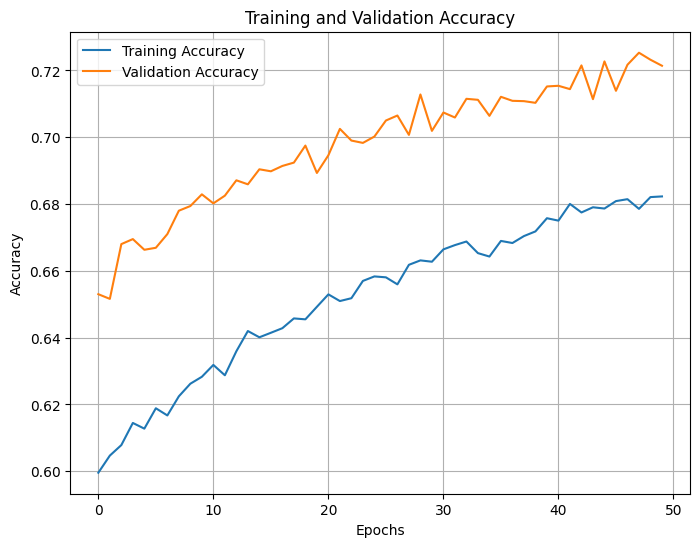

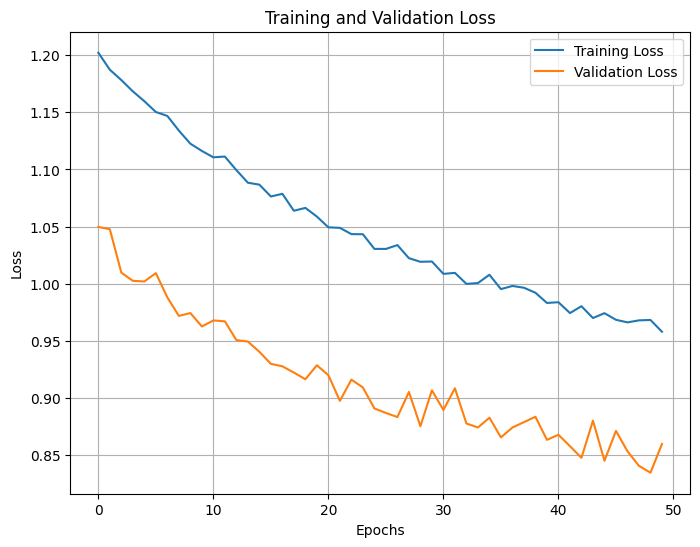

In [14]:
# Accuracy curves
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss curves
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## 🎯 **Step 8: Model Evaluation and Performance Analysis**

### 📋 **Comprehensive Evaluation Metrics:**

**✅ Test Accuracy**: Overall percentage of correctly classified images

**📊 Classification Report**: Detailed per-class performance
- **Precision**: Of predicted class X, how many were actually X?
- **Recall**: Of actual class X, how many were correctly identified?
- **F1-Score**: Harmonic mean of precision and recall
- **Support**: Number of true instances for each class

**🔥 Confusion Matrix**: Visual representation of classification results
- **Rows**: True labels (ground truth)
- **Columns**: Predicted labels (model output)
- **Diagonal**: Correct predictions
- **Off-diagonal**: Classification errors

This helps identify which classes the model confuses with each other.


Evaluating on CIFAR-10 test dataset...
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

✅ Test Accuracy: 0.7175

=== Classification Report ===
              precision    recall  f1-score   support

    airplane       0.74      0.74      0.74      1000
  automobile       0.83      0.84      0.84      1000
        bird       0.70      0.56      0.62      1000
         cat       0.63      0.45      0.52      1000
        deer       0.72      0.63      0.67      1000
         dog       0.73      0.57      0.64      1000
        frog       0.61      0.87      0.72      1000
       horse       0.73      0.81      0.77      1000
        ship       0.83      0.83      0.83      1000
       truck       0.68      0.87      0.77      1000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.71     10000
weighted avg       0.72      0.72      0.71     10000


✅ Test Accuracy: 0.7175

=== Classification Report ===
       

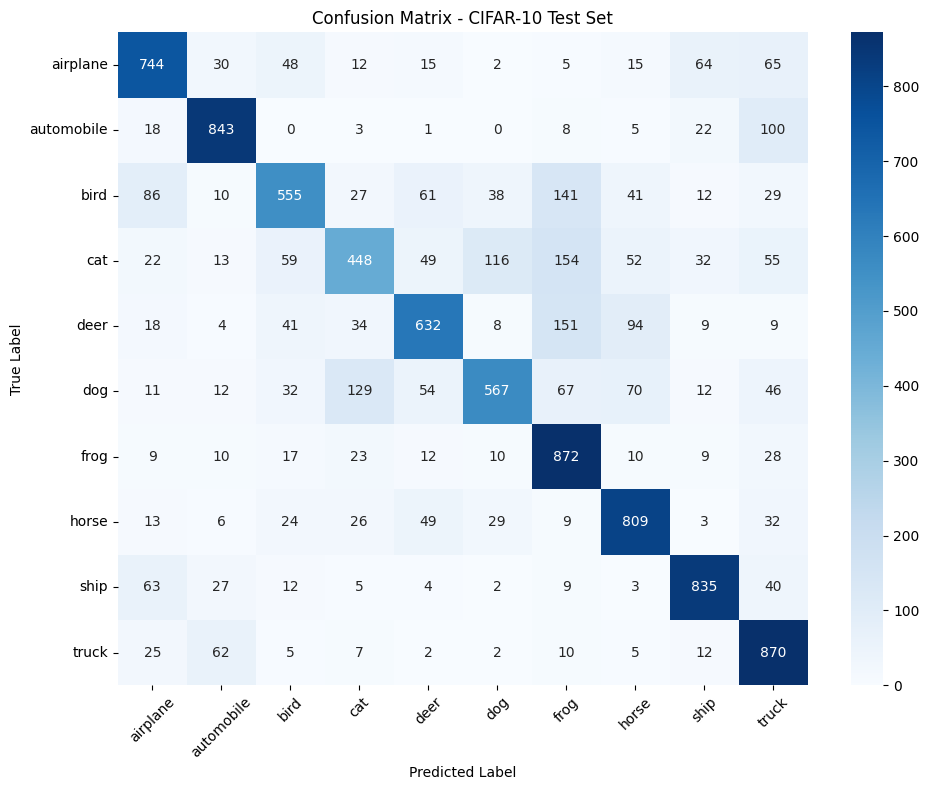

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# === Evaluate model ===
print("\nEvaluating on CIFAR-10 test dataset...")
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_pred = np.argmax(model.predict(test_ds), axis=1)

# === CIFAR-10 class names ===
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# === Accuracy ===
accuracy = np.mean(y_true == y_pred)
print(f"\n✅ Test Accuracy: {accuracy:.4f}\n")

# === Classification Report ===
print("=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_names))

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - CIFAR-10 Test Set')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 🔍 **Step 9: Individual Predictions Analysis**

### 🖼️ **Visual Prediction Analysis:**
Let's examine individual test samples to understand model behavior:

**🎯 Sample Predictions Grid**: 
- Shows 12 random test images with predictions
- **Green titles**: Correct predictions ✅
- **Red titles**: Incorrect predictions ❌
- **Confidence scores**: Model's certainty level (0-100%)

**📊 Per-Class Accuracy Breakdown**:
- Individual accuracy for each of the 10 CIFAR-10 classes
- Identifies which classes are easier/harder to classify
- Shows sample count per class for statistical significance

### 💡 **Insights to Discover:**
- Which classes does the model predict most accurately?
- Are there common misclassification patterns?
- Does the model struggle with visually similar classes?
- How confident is the model in its predictions?

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


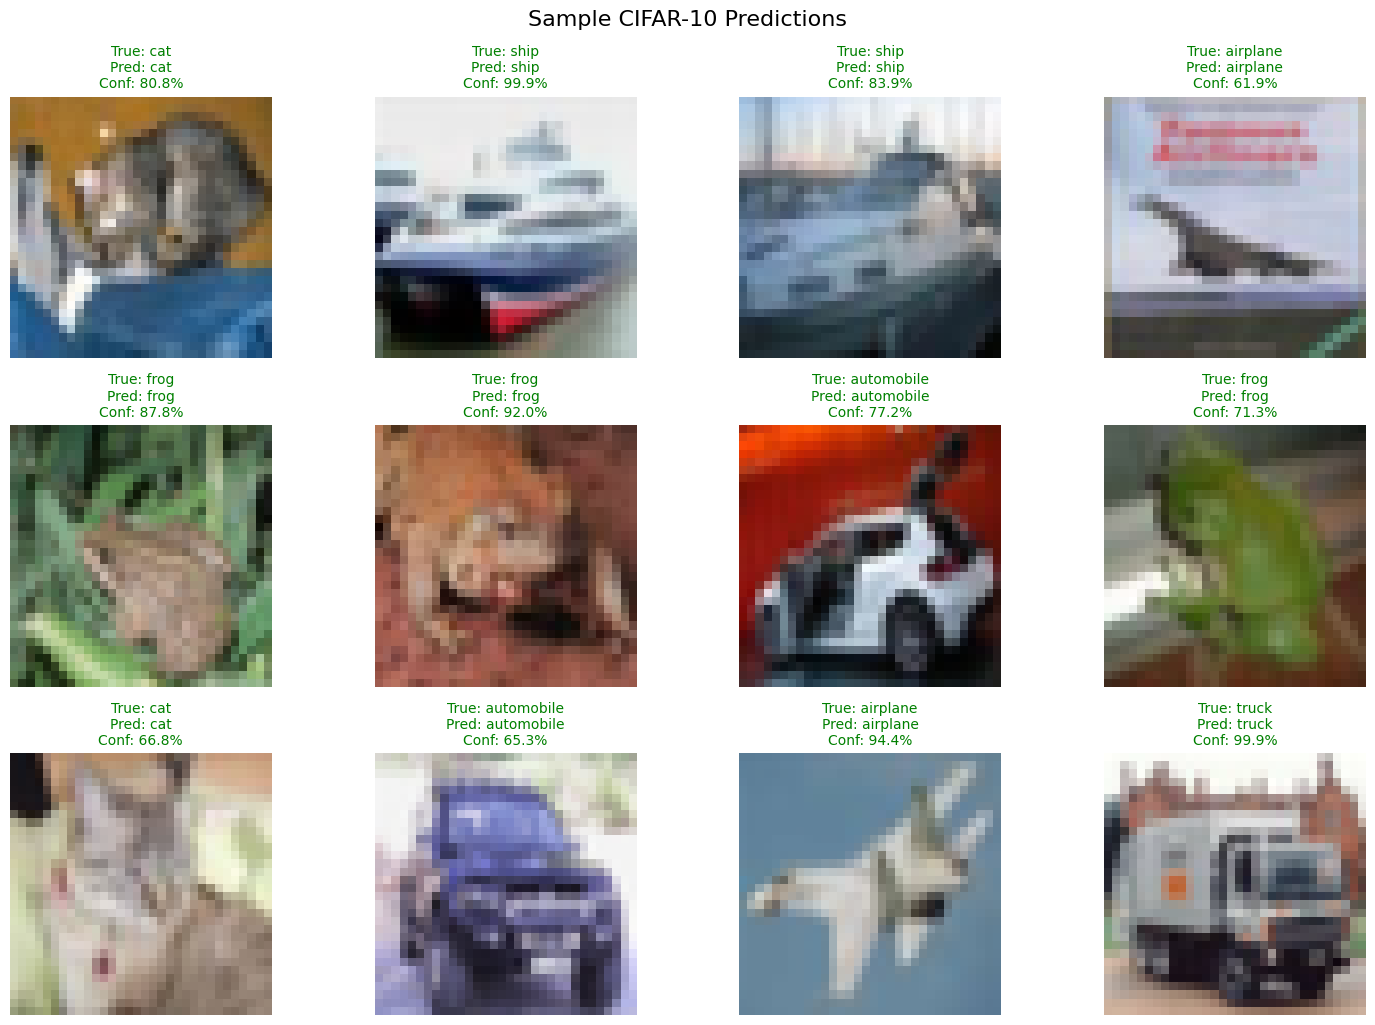


=== Per-class Accuracy ===
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
airplane    : 0.7440 (1000 samples)
automobile  : 0.8430 (1000 samples)
bird        : 0.5550 (1000 samples)
cat         : 0.4480 (1000 samples)
deer        : 0.6320 (1000 samples)
dog         : 0.5670 (1000 samples)
frog        : 0.8720 (1000 samples)
horse       : 0.8090 (1000 samples)
ship        : 0.8350 (1000 samples)
truck       : 0.8700 (1000 samples)
airplane    : 0.7440 (1000 samples)
automobile  : 0.8430 (1000 samples)
bird        : 0.5550 (1000 samples)
cat         : 0.4480 (1000 samples)
deer        : 0.6320 (1000 samples)
dog         : 0.5670 (1000 samples)
frog        : 0.8720 (1000 samples)
horse       : 0.8090 (1000 samples)
ship        : 0.8350 (1000 samples)
truck       : 0.8700 (1000 samples)


In [16]:
# === Visualize Sample Predictions ===
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

# Get a batch of test data
test_images, test_labels = next(iter(test_ds))
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Plot the first 12 test images with predictions
plt.figure(figsize=(15, 10))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(test_images[i])
    true_label = class_names[test_labels[i]]
    pred_label = class_names[predicted_classes[i]]
    confidence = np.max(predictions[i]) * 100
    
    # Color code: green for correct, red for incorrect
    color = 'green' if test_labels[i] == predicted_classes[i] else 'red'
    plt.title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%', 
              color=color, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.suptitle('Sample CIFAR-10 Predictions', fontsize=16, y=1.02)
plt.show()

# === Per-class accuracy ===
print("\n=== Per-class Accuracy ===")
y_true_all = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_pred_all = np.argmax(model.predict(test_ds), axis=1)

for i, class_name in enumerate(class_names):
    class_mask = (y_true_all == i)
    if np.sum(class_mask) > 0:
        class_accuracy = np.mean(y_pred_all[class_mask] == y_true_all[class_mask])
        print(f"{class_name:12}: {class_accuracy:.4f} ({np.sum(class_mask)} samples)")

In [17]:
# === Model and Dataset Summary ===
print("🔥 CIFAR-10 CNN Model Summary")
print("="*50)
print(f"📊 Dataset: CIFAR-10 (32x32 RGB images)")
print(f"📁 Classes: {len(class_names)} categories")
print(f"🏷️  Class Names: {', '.join(class_names)}")
print(f"🔢 Training samples: {len(x_train)}")
print(f"🔢 Validation samples: {len(x_val)}")  
print(f"🔢 Test samples: {len(x_test)}")
print()
print("🧠 Model Architecture:")
print(f"   • Input shape: {img_size + (3,)}")
print(f"   • Conv layers: 3 (16, 32, 64 filters)")
print(f"   • Dense layers: 2 (64 neurons + 10 output)")
print(f"   • Output: {len(class_names)} classes (softmax)")
print(f"   • Total parameters: {model.count_params():,}")
print("="*50)

🔥 CIFAR-10 CNN Model Summary
📊 Dataset: CIFAR-10 (32x32 RGB images)
📁 Classes: 10 categories
🏷️  Class Names: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
🔢 Training samples: 40000
🔢 Validation samples: 10000
🔢 Test samples: 10000

🧠 Model Architecture:
   • Input shape: (32, 32, 3)
   • Conv layers: 3 (16, 32, 64 filters)
   • Dense layers: 2 (64 neurons + 10 output)
   • Output: 10 classes (softmax)
   • Total parameters: 90,294
